<a href="https://colab.research.google.com/github/GlennWSo/case_colab/blob/main/Case_evening_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive to be able to access the folder of the project
from google.colab import drive

drive.mount('/content/drive')
%cd '/content/drive/MyDrive/CaseEvening/'

# import sys
# sys.path.insert(0,'/content/drive/MyDrive/CaseEvening/')

Mounted at /content/drive
/content/drive/MyDrive/CaseEvening


#  <u>The Dataset </u>
The dataset used for this case is the [*Respiratory Sound Database*](https://bhichallenge.med.auth.gr/ICBHI_2017_Challenge) used at the  Int. Conf. on Biomedical Health Informatics - ICBHI 2017. 


---
The collection includes audio samples that two study teams separately gathered. The dataset consists of **920 annotated audio samples** from **126 participants** that span **a total of 5.5 hours** and **contain 6898 respiratory cycles**, of which **1864 have crackles**, **886 have wheezes**, and **506 have both**.


---

The audio samples were collected using different equipments and the **duration can range from 10s to 90s**. The samples were taken from **several places on the chest**, and some of them include a lot of noise, simulating real-world settings.


---

The dataset includes samples for both a **healthy state** and **seven different disease disorders**. Following is a distribution of the samples by the class to which they belong:


*   COPD (Chronic Obstructive Pulmonary Disease)- 793 samples
*   Bronchiectasis - 16 samples
*   Bronchiolitis - 13 samples
*   URTI (Upper Respiratory Tract Infection) - 23 samples
*   Pneumonia - 37 samples
*   Asthma - 1 sample
*   LRTI (Lower Respiratory Tract Infection) - 2 samples
*   Healthy - 35 samples



---









#  <u> Our approach </u>

<u>**Feature extraction**</u> <br>
The feature extraction performed here consists of computing the following metrics for each sample from the dataset:


*   40 mfcc coefficients
*   12 values corresponding to chroma
*   128 values corresponding to Mel spectrogram
*   7 values corresponding to the spectral contrast
*   6 values corresponding to the Tonnetz.

For each sample, a list is generated and it contains the mentioned metrics in the order mentioned above. The list has in total 193 elements.





<u>**Description of the metrics**</u> 


1.   <u>MFCC (Mel frequency cepstral coefficients)</u> <br>
The mel frequency cepstral coefficients of a signal are a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope. In music information retrieval, it is often used to describe timbre.
2.   <u>Chroma</u> <br> 
Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave.
3. <u>Mel Spectrogram</u> <br> 
A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. The Mel scale is a scale of pitches that human hearing generally perceives to be equidistant from each other. As frequency increases, the interval, in hertz, between Mel scale values (or simply mels) increases. The Mel spectrogram remaps the values in hertz to the Mel scale.
4. <u>Spectral contrast</u> <br> 
In an audio signal, the spectral contrast is the measure of the energy of frequency at each timestamp. Since most of the audio files contain the frequency whose energy is changing with time, it becomes difficult to measure the level of energy. Spectral contrast is a way to measure that energy variation.
5. <u>Tonal Centroid Features (Tonnetz)</u> <br> 
To compute this metric, it is considered that the audio file is of 6 pitch classes by merging some of the chroma classes together.



##  <u> The model </u>



*   **Sequential model** - a linear stack of layers.
*   **Conv1D layer** - Convolution is a linear operation that involves a multiplicating of weights (also known as kernel) with input and producing an output.
*   **MaxPooling1D layer** - Downsamples the input representation by taking the maximum value over a spatial window of specified size.
*  **The Dropout layer** - Randomly sets input units to 0 with a specified frequency at each step during training time, which helps prevent overfitting.
*   **Flatten layer** - Flattens the input without affecting the batch size.
*   **Dense layer** - A dense layer is a layer that is deeply connected with its preceding layer which means the neurons of the layer are connected to every neuron of its preceding layer. 


#  <u> Implementation </u>

In [ ]:
#Import necessary libraries 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from helper import predict_on_sample
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from keras.models import load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#PATHS

DATASET_FEATURES_PATH = 'dataset_features.csv'# Each row corresponds to an audio file from the dataset and contains 193 feature extracted from the audio file
DATASET_CLASSES_PATH = 'classes.csv'# Each row contains a string that represents the diagnose corresponding to the audio file 


In [ ]:
#Loading the dataset

data = np.genfromtxt(DATASET_FEATURES_PATH, delimiter=",")
classes= np.genfromtxt(DATASET_CLASSES_PATH, delimiter=",",dtype=str)

In [ ]:
#Label encoding

le = preprocessing.LabelEncoder() 
labels_encoded_integer = le.fit_transform(classes) #Encode target labels with value between 0 and n_classes-1.
labels_encoded_one_hot = to_categorical(labels_encoded_integer)

In [ ]:
#Splitting the dataset into train and test datasets

X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded_one_hot, test_size=0.3, random_state=10)


# Format the train/test data
y_train = np.reshape(y_train, (y_train.shape[0], 6))
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 6))
X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

In [ ]:
# CNN Model architecture

model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Conv1D(256, kernel_size=5, activation='relu'))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 189, 64)           384       
                                                                 
 conv1d_4 (Conv1D)           (None, 185, 128)          41088     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 92, 128)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 88, 256)           164096    
                                                                 
 dropout_1 (Dropout)         (None, 88, 256)           0         
                                                                 
 flatten_1 (Flatten)         (None, 22528)             0         
                                                      

In [ ]:
# custom_early_stopping = EarlyStopping(
#     monitor='val_accuracy', 
#     patience=8, 
#     min_delta=0.05, 
#     mode='max'
# )

In [ ]:

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=200, verbose=1)
model.save('TrainedModel - batch 200.h5')

Epoch 1/150
4/4 [==============================] - 7s 2s/step - loss: 4.1981e-04 - accuracy: 1.0000 - val_loss: 0.5710 - val_accuracy: 0.9493
Epoch 2/150
4/4 [==============================] - 4s 1s/step - loss: 0.0029 - accuracy: 0.9984 - val_loss: 0.5745 - val_accuracy: 0.9420
Epoch 3/150
4/4 [==============================] - 4s 1s/step - loss: 1.4632e-04 - accuracy: 1.0000 - val_loss: 0.5868 - val_accuracy: 0.9384
Epoch 4/150
4/4 [==============================] - 7s 2s/step - loss: 6.1811e-04 - accuracy: 1.0000 - val_loss: 0.5889 - val_accuracy: 0.9348
Epoch 5/150
4/4 [==============================] - 4s 1s/step - loss: 7.9929e-04 - accuracy: 1.0000 - val_loss: 0.5740 - val_accuracy: 0.9420
Epoch 6/150
4/4 [==============================] - 8s 2s/step - loss: 1.7312e-04 - accuracy: 1.0000 - val_loss: 0.5627 - val_accuracy: 0.9457
Epoch 7/150
4/4 [==============================] - 5s 1s/step - loss: 5.0766e-04 - accuracy: 1.0000 - val_loss: 0.5662 - val_accuracy: 0.9420
Epoch 8/15

Accuracy: 94%
Loss: 0.5616



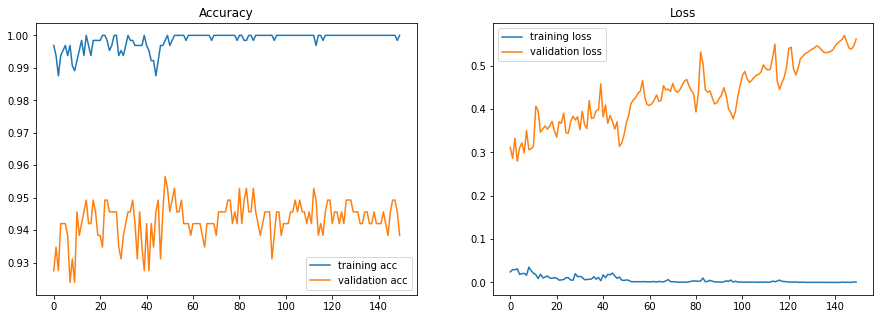

In [ ]:
#Training history

score = model.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

plt.savefig('Learning curves.png')

##  <u> Testing the model </u>

In [ ]:
lung_disease_classifier = load_model('TrainedModel - final.h5')

In [ ]:
test_sample_path = "ICBHI Dataset - Class separated/Bronchiolitis/149_1b1_Lr_sc_Meditron.wav"

In [ ]:
#@title Prediction of the health situation
prediction = predict_on_sample(test_sample_path, lung_disease_classifier, DATASET_CLASSES_PATH)

1/1 [==============================] - 0s 176ms/step
The patient is diagnosed with Bronchiolitis


In [ ]:
predictions_on_new_audio_data =pd.read_csv("Model predictions on new audio samples.csv", index_col=False)

In [ ]:
predictions_on_new_audio_data

,Diagnose,Predicted diagnose
0,URTI,COPD
1,URTI,COPD
2,URTI,COPD
3,URTI,COPD
4,URTI,Bronchiolitis
5,URTI,URTI
6,URTI,URTI
7,URTI,COPD
8,LRTI,COPD
9,LRTI,COPD
